In [1]:
import bambi as bmb

In [13]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('poster')

In [7]:
df = pd.read_csv('./data/netflix_merged.csv')

cols_of_interest = ['Days In Top 10', 'year', 'Netflix Exclusive', 'Viewership Score']

df_sel = df[cols_of_interest]
df_sel.columns = [key.replace(' ', '_') for key in cols_of_interest] #bambi has some problems with whitespaces

In [11]:
md = bmb.Model(data=df_sel, 
               formula='Days_In_Top_10 ~ Netflix_Exclusive + Viewership_Score',
               family='poisson',
               link='log')

In [12]:
mdf = md.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Netflix_Exclusive, Viewership_Score]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.


In [14]:
az.summary(mdf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.453,0.034,1.393,1.520,0.001,0.000,2397.0,1792.0,1.0
Netflix_Exclusive[Yes],-0.163,0.045,-0.253,-0.084,0.001,0.001,1739.0,1514.0,1.0
Viewership_Score,0.020,0.001,0.019,0.021,0.000,0.000,1531.0,1341.0,1.0


In [18]:
md.predict(mdf, kind='pps')

<AxesSubplot:xlabel='Days_In_Top_10 / Days_In_Top_10'>

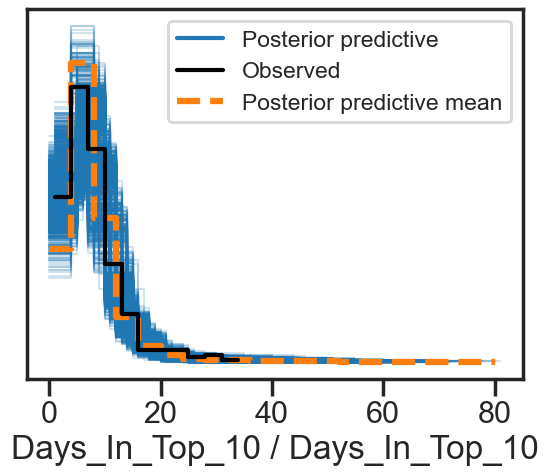

In [19]:
az.plot_ppc(mdf)